In [704]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import gensim
import numpy as np
import sys
import torch
import nltk
import math
import re
import matplotlib
import seaborn as sns
import os
import subprocess 
import json
import spacy
import warnings

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import cosine, euclidean
from nltk.tokenize import RegexpTokenizer
from string import punctuation
from nltk.tokenize import TextTilingTokenizer
from string import punctuation
from sklearn.preprocessing import normalize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from random import randint
from nltk.tokenize import word_tokenize 
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans


sys.path.append('./InferSent.git/trunk/')
from models import InferSent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ataxali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Please download the GloVe and Word2Vec models as mentioned in the report and update paths below

In [4]:
glove_model_loc = '../../sst/pretrained_models/glove.840B.300d.word2vec.mmap'
word2vec_model_loc = '../../sst/pretrained_models/GoogleNews-vectors-negative300.mmap'

#### Class below ensures only one copy of each embedding is loaded into memory

In [5]:
class Pretrained_Embeddings():
    def __init__(self):
        self.glove_model = None
        self.word2vec_model = None
                
    def init_glove_model(self):
        if self.glove_model is None:
            print('Loading model into memory...')
            self.glove_model = gensim.utils.SaveLoad.load(glove_model_loc, mmap='r')
            #self.glove_model = KeyedVectors.load_word2vec_format(glove_model_loc, binary=False)        
    
    def init_word2vec_model(self):
        if self.word2vec_model is None:
            print('Loading model into memory...')
            self.word2vec_model = gensim.utils.SaveLoad.load(word2vec_model_loc, mmap='r')
            #self.word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_model_loc, binary=True)        

    def additive_cosine_dist(self, x, y, model):
        x, y = x.lower().split(), y.lower().split()
        x_vec, y_vec = np.zeros(model.vector_size), np.zeros(model.vector_size)
        n_x, n_y = 0, 0
        for x_i in x:
            if x_i in model: 
                x_vec += model[x_i]
                n_x += 1
        for y_i in y: 
            if y_i in model: 
                y_vec += model[y_i]
                n_y += 1
        x_vec = np.divide(x_vec, n_x)
        y_vec = np.divide(y_vec, n_y)
        ## check if x/y vectors are both all zeros
        if (not np.any(x_vec)) and (not np.any(y_vec)):
            return np.float('nan')
        else:
            # cosine is 0 when same vector (distance)
            # below returns cosine similarity
            return 1 - cosine(x_vec, y_vec)  

       
    def glove_cosine_dist(self, x, y, weight_dict_x=None, weight_dict_y=None):
        if self.glove_model is None: self.init_glove_model()
        return self.additive_cosine_dist(x, y, self.glove_model)
     
    def word2vec_cosine_dist(self, x, y, weight_dict_x=None, weight_dict_y=None):
        if self.word2vec_model is None: self.init_word2vec_model()
        return self.additive_cosine_dist(x, y, self.word2vec_model)   
        
pretrained_singleton = Pretrained_Embeddings()

#### Testing to ensure embeddings are loaded correctly

In [6]:
pretrained_singleton.glove_cosine_dist('hello what is your name', 'hello what is your name')

Loading model into memory...


1.0

In [7]:
pretrained_singleton.word2vec_cosine_dist('hello what is your name', 'hello what is your name')

Loading model into memory...


1.0

In [8]:
pretrained_singleton.glove_cosine_dist('hello what is your name', 'the dog ran in the park')

0.668887703959695

In [9]:
pretrained_singleton.word2vec_cosine_dist('hello what is your name', 'the dog ran in the park')

0.3529431706648032

#### Please download the Infersent model as mentioned in report

In [10]:
# Load model
model_version = 2
MODEL_PATH = "./InferSent.git/trunk/encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

# Keep it on CPU or put it on GPU
use_cuda = False
inf_model = model.cuda() if use_cuda else model

# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = './InferSent.git/trunk/dataset/GloVe/glove.840B.300d.txt' if model_version == 1 else './InferSent.git/trunk/dataset/fastText/crawl-300d-2M.vec'
inf_model.set_w2v_path(W2V_PATH)

#### Please download the Transformer model as mentioned in report

In [11]:
def sentence_encoder(sentences):
    import tensorflow as tf
    import tensorflow_hub as hub
    # Reduce logging output.
    tf.logging.set_verbosity(tf.logging.ERROR)

    module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" 
    os.environ['TFHUB_CACHE_DIR'] = '/home/ataxali/tf_hub'
    embed = hub.Module(module_url)
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        sentence_vecs = session.run(embed(sentences))
        session.close()
    tf.reset_default_graph()

    return sentence_vecs

#### Load the dataset

In [241]:
df = pd.read_csv('./sentence_pairs.csv')
## apply minimal preprocessing (section 3)
r = re.compile(r'[{}]+'.format(re.escape(punctuation)))  # remove punctuations
dat_df = pd.DataFrame()
dat_df['sen_A'] = df.sentenceA.map(lambda y: r.sub('', y.lower()))
dat_df['sen_B'] = df.sentenceB.map(lambda y: r.sub('', y.lower()))
dat_df['sim_mean'] = df.to_what_extent_are_the_two_sentences_expressing_a_related_meaning.astype(np.float)
dat_df['sim_var'] = df[['to_what_extent__are_the_two_sentences_expressing_a_related_meaning:variance']].astype(np.float)

In [242]:
dat_df.head()

,sen_A,sen_B,sim_mean,sim_var
0,a girl is riding a horse,a girl is riding a brown horse,4.40,0.490
1,a man is riding a skateboard in a park,a man is riding a skateboard,4.77,0.421
2,a woman is eating and drinking with other women,some women are eating and drinking,4.92,0.266
3,a person is playing a drum,a red car is on the shirt of a man,1.00,0.000
4,a cat is resting on a chair,an onion is being cut by a man,1.00,0.000


In [498]:
vocab = set()
for sent in np.concatenate([dat_df.sen_A, dat_df.sen_B]):
    for word in sent.split():
        vocab.add(word)
len(vocab)

1118

In [500]:
sen_lens = [len(s.split()) for s in np.concatenate([dat_df.sen_A, dat_df.sen_B])]
np.mean(sen_lens)

9.248648648648649

#### Code for Section 4 in report

In [14]:
def rescale_vec(X, minv=1, maxv=5):
    X_std = (X - min(X)) / (max(X) - min(X))
    X_scaled = X_std * (maxv - minv) + minv
    return X_scaled

In [363]:
def compute_sims(dat_df):
    print('Working on glove...')
    cosine_sims = []
    for index, row in dat_df.iterrows():
        sen_a = row.sen_A
        sen_b = row.sen_B
        cosine_sims.append(pretrained_singleton.glove_cosine_dist(sen_a, sen_b))
    dat_df['glove_sims'] = rescale_vec(np.array(cosine_sims).flatten())
    
    print('Working on word2vec...')
    cosine_sims = []
    for index, row in dat_df.iterrows():
        sen_a = row.sen_A
        sen_b = row.sen_B
        cosine_sims.append(pretrained_singleton.word2vec_cosine_dist(sen_a, sen_b))
    dat_df['word2vec_sims'] = rescale_vec(np.array(cosine_sims).flatten())
    
    print('Working on infersent...')
    sentences = np.concatenate([dat_df.sen_A, dat_df.sen_B])
    inf_model.build_vocab(sentences, tokenize=False)
    embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)
    infersent_vectors = dict()
    for i, sen in enumerate(sentences):
        infersent_vectors[sen] = embeddings[i]
    cosine_sims = []
    for index, row in dat_df.iterrows():
        sen_a = row.sen_A
        sen_b = row.sen_B
        cosine_sims.append(1 - cosine(infersent_vectors[sen_a].reshape(1, -1), infersent_vectors[sen_b].reshape(1, -1)))
    dat_df['infersent_sims'] = rescale_vec(np.array(cosine_sims).flatten())
    
    print('Working on transformer...')
    sentence_encoder_vecs = sentence_encoder(sentences)
    s_enc_dict = {x[0]:x[1] for x in zip(np.concatenate([dat_df.sen_A, dat_df.sen_B]), sentence_encoder_vecs)}
    cosine_sims = []
    for index, row in dat_df.iterrows():
        sen_a = row.sen_A
        sen_b = row.sen_B
        cosine_sims.append(1 - cosine(s_enc_dict[sen_a].reshape(1, -1), s_enc_dict[sen_b].reshape(1, -1)))
    dat_df['sen_enc_sims'] = rescale_vec(np.array(cosine_sims).flatten())
    
    return dat_df

In [ ]:
dat_df_1 = compute_sims(dat_df)

In [366]:
dat_df_1.head()

,sen_A,sen_B,sim_mean,sim_var,glove_sims,word2vec_sims,infersent_sims,sen_enc_sims,upper_true_1sd,lower_true_1sd,upper_true_2sd,lower_true_2sd
0,a girl is riding a horse,a girl is riding a brown horse,4.40,0.490,4.803434,4.669749,4.237167,4.096929,5.0,3.700000,5.0,3.000000
1,a man is riding a skateboard in a park,a man is riding a skateboard,4.77,0.421,4.782162,4.613463,4.294548,4.036732,5.0,4.121155,5.0,3.472310
2,a woman is eating and drinking with other women,some women are eating and drinking,4.92,0.266,4.475363,4.281820,4.324159,4.665819,5.0,4.404248,5.0,3.888496
3,a person is playing a drum,a red car is on the shirt of a man,1.00,0.000,3.621263,1.909154,1.376006,1.600667,1.0,1.000000,1.0,1.000000
4,a cat is resting on a chair,an onion is being cut by a man,1.00,0.000,3.237548,1.369710,1.470808,1.892490,1.0,1.000000,1.0,1.000000


In [25]:
dat_df_1.isna().sum()

sen_A             0
sen_B             0
sim_mean          0
sim_var           0
glove_sims        0
word2vec_sims     0
infersent_sims    0
sen_enc_sims      0
dtype: int64

In [237]:
def print_mse_res(dat_df):
    if 'glove_sims' in dat_df.columns:
        print("glove: {}".format(mean_squared_error(dat_df.sim_mean, dat_df.glove_sims)))
    if 'word2vec_sims' in dat_df.columns:
        print("word2vec: {}".format(mean_squared_error(dat_df.sim_mean, dat_df.word2vec_sims)))
    if 'infersent_sims' in dat_df.columns:
        print("infersent: {}".format(mean_squared_error(dat_df.sim_mean, dat_df.infersent_sims)))
    if 'sen_enc_sims' in dat_df.columns:
        print("transformer: {}".format(mean_squared_error(dat_df.sim_mean, dat_df.sen_enc_sims)))

#### Results for Section 4 in report

In [238]:
print_mse_res(dat_df_1)

glove: 1.333031271057277
word2vec: 0.6399756517056833
infersent: 0.566002555027683
transformer: 0.4907815819032301


In [262]:
dat_df_1['upper_true_1sd'] = np.clip(dat_df_5.sim_mean + np.sqrt(dat_df_5.sim_var), 1, 5)
dat_df_1['lower_true_1sd'] = np.clip(dat_df_5.sim_mean - np.sqrt(dat_df_5.sim_var), 1, 5)

dat_df_1['upper_true_2sd'] = np.clip(dat_df_5.sim_mean + 2*np.sqrt(dat_df_5.sim_var), 1, 5)
dat_df_1['lower_true_2sd'] = np.clip(dat_df_5.sim_mean - 2*np.sqrt(dat_df_5.sim_var), 1, 5)

In [260]:
for col in ['glove_sims', 'word2vec_sims', 'infersent_sims', 'sen_enc_sims']:
    print(col, np.sum((dat_df_1[col] <= dat_df_1.upper_true_1sd) & 
                      (dat_df_1[col] >= dat_df_1.lower_true_1sd)) / dat_df_1.shape[0])

glove_sims 0.5585585585585585
word2vec_sims 0.6252252252252253
infersent_sims 0.6234234234234234
sen_enc_sims 0.6774774774774774


In [259]:
for col in ['glove_sims', 'word2vec_sims', 'infersent_sims', 'sen_enc_sims']:
    print(col, np.sum((dat_df_1[col] <= dat_df_1.upper_true_2sd) & 
                      (dat_df_1[col] >= dat_df_1.lower_true_2sd)) / dat_df_1.shape[0])

glove_sims 0.7585585585585586
word2vec_sims 0.7927927927927928
infersent_sims 0.7981981981981981
sen_enc_sims 0.8108108108108109


In [78]:
outlier_errs = dat_df_1[(dat_df_1.sim_mean < 2.5) & (dat_df_1.glove_sims > 4.5) &  (dat_df_1.word2vec_sims > 4.5)]
outlier_errs

,sen_A,sen_B,sim_mean,sim_var,glove_sims,word2vec_sims,infersent_sims,sen_enc_sims
222,a dog is not running towards a ball,a dog is running towards a ball,2.2,1.166,4.937679,4.86148,3.872109,4.234704


In [140]:
def get_sent_vecs(sent):
    glove_vec = np.zeros(pretrained_singleton.glove_model.vector_size)
    n_glove = 0
    for w in sent.split():
        if w in pretrained_singleton.glove_model:
            glove_vec += pretrained_singleton.glove_model[w]
            n_glove += 1
    glove_vec = np.divide(glove_vec, n_glove)
    
    word2vec_vec = np.zeros(pretrained_singleton.word2vec_model.vector_size)
    n_word2vec = 0
    for w in sent.split():
        if w in pretrained_singleton.word2vec_model:
            word2vec_vec += pretrained_singleton.word2vec_model[w]
            n_word2vec += 1
    word2vec_vec = np.divide(word2vec_vec, n_word2vec)
    
    inf_model.build_vocab(sent, tokenize=False)
    embeddings = model.encode(sent, bsize=128, tokenize=False, verbose=True)
    inf_vec = embeddings[0]
    
    transformer_vec = sentence_encoder([sent])
    
    return glove_vec, word2vec_vec, inf_vec, transformer_vec

In [178]:
def get_sents_vecs(sents):
    glove_vecs = []
    for sent in sents:
        glove_vec = np.zeros(pretrained_singleton.glove_model.vector_size)
        n_glove = 0
        for w in sent.split():
            if w in pretrained_singleton.glove_model:
                glove_vec += pretrained_singleton.glove_model[w]
                n_glove += 1
        glove_vec = np.divide(glove_vec, n_glove)
        glove_vecs.append(glove_vec)

    word2vec_vecs = []
    for sent in sents:
        word2vec_vec = np.zeros(pretrained_singleton.word2vec_model.vector_size)
        n_word2vec = 0
        for w in sent.split():
            if w in pretrained_singleton.word2vec_model:
                word2vec_vec += pretrained_singleton.word2vec_model[w]
                n_word2vec += 1
        word2vec_vec = np.divide(word2vec_vec, n_word2vec)
        word2vec_vecs.append(word2vec_vec)
    
    inf_model.build_vocab(sents, tokenize=False)
    embeddings = model.encode(sents, bsize=128, tokenize=False, verbose=True)
    inf_vecs = embeddings
    
    transformer_vecs = sentence_encoder(sents)
    
    return glove_vecs, word2vec_vecs, inf_vecs, transformer_vecs

In [191]:
sentences = np.concatenate([dat_df_1.sen_A, dat_df_1.sen_B])
sents_vecs = list(get_sents_vecs(sentences))

Found 1119(/1120) words with w2v vectors
Vocab size : 1119
Nb words kept : 12485/12486 (100.0%)
Speed : 84.4 sentences/s (cpu mode, bsize=128)


In [192]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=300, random_state=42)
all_glove_vecs = sents_vecs[0]
all_word2vec_vecs = sents_vecs[1]
tsne_results_glove = tsne.fit_transform(all_glove_vecs)
tsne_results_word2vec = tsne.fit_transform(all_word2vec_vecs)

In [184]:
sent_a_idx = list(sentences).index('a dog is not running towards a ball')
sent_b_idx = list(sentences).index('a dog is running towards a ball')

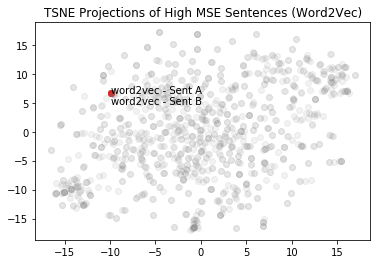

In [185]:
fig, ax = plt.subplots()
ax.scatter(tsne_results_word2vec[sent_a_idx, 0], tsne_results_word2vec[sent_a_idx, 1], c='red')
ax.scatter(tsne_results_word2vec[sent_b_idx, 0], tsne_results_word2vec[sent_b_idx, 1], c='red')
ax.scatter(tsne_results_word2vec[:, 0], tsne_results_word2vec[:, 1], c='gray', alpha=0.1)
ax.annotate('word2vec - Sent A', (tsne_results_word2vec[sent_a_idx, 0],
                                  tsne_results_word2vec[sent_a_idx, 1]))
ax.annotate('word2vec - Sent B', (tsne_results_word2vec[sent_b_idx, 0], 
                                  tsne_results_word2vec[sent_b_idx, 1]-2))
ax.set_title('TSNE Projections of High MSE Sentences (Word2Vec)')
plt.show()

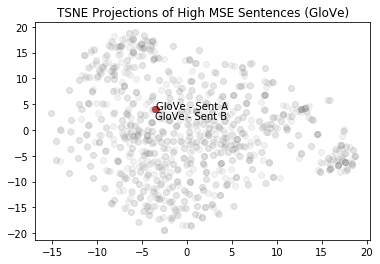

In [186]:
fig, ax = plt.subplots()
ax.scatter(tsne_results_glove[sent_a_idx, 0], tsne_results_glove[sent_a_idx, 1], c='red')
ax.scatter(tsne_results_glove[sent_b_idx, 0], tsne_results_glove[sent_b_idx, 1], c='red')
ax.scatter(tsne_results_glove[:, 0], tsne_results_glove[:, 1], c='gray', alpha=0.1)
ax.annotate('GloVe - Sent A', (tsne_results_glove[sent_a_idx, 0], 
                               tsne_results_glove[sent_a_idx, 1]))
ax.annotate('GloVe - Sent B', (tsne_results_glove[sent_b_idx, 0], 
                               tsne_results_glove[sent_b_idx, 1]-2))
ax.set_title('TSNE Projections of High MSE Sentences (GloVe)')
plt.show()

#### Code for Section 5 in report

In [23]:
stopwords_set = set(stopwords.words('english'))
dat_df_2 = dat_df.copy()
dat_df_2.sen_A = dat_df_2.sen_A.map(lambda x: " ".join([w for w in x.split() if w not in stopwords_set]))
dat_df_2.sen_B = dat_df_2.sen_B.map(lambda x: " ".join([w for w in x.split() if w not in stopwords_set]))

In [24]:
dat_df_2 = compute_sims(dat_df_2)

Working on glove...
Working on word2vec...
Working on infersent...
Found 1063(/1064) words with w2v vectors
Vocab size : 1063
Nb words kept : 7486/7487 (100.0%)
Speed : 155.7 sentences/s (cpu mode, bsize=128)
Working on transformer...


In [26]:
dat_df_2.head()

,sen_A,sen_B,sim_mean,sim_var,glove_sims,word2vec_sims,infersent_sims,sen_enc_sims
0,girl riding horse,girl riding brown horse,4.40,0.490,4.670091,4.692324,4.282084,4.156296
1,man riding skateboard park,man riding skateboard,4.77,0.421,4.689159,4.698774,4.434809,4.257569
2,woman eating drinking women,women eating drinking,4.92,0.266,4.791728,4.706641,4.703714,4.648295
3,person playing drum,red car shirt man,1.00,0.000,1.964802,1.730050,1.644885,1.428785
4,cat resting chair,onion cut man,1.00,0.000,1.314696,1.000000,1.728698,1.466861


In [27]:
dat_df_2.isna().sum()

sen_A             0
sen_B             0
sim_mean          0
sim_var           0
glove_sims        0
word2vec_sims     0
infersent_sims    0
sen_enc_sims      0
dtype: int64

#### Results for Section 5 in report

In [66]:
print_mse_res(dat_df_2)

glove: 0.8118139474617215
word2vec: 0.6407317653910207
infersent: 0.58992426933023
transformer: 0.5673466989399255


In [194]:
sentences = np.concatenate([dat_df_2.sen_A, dat_df_2.sen_B])
sents_vecs = list(get_sents_vecs(sentences))

Found 1063(/1064) words with w2v vectors
Vocab size : 1063
Nb words kept : 7486/7487 (100.0%)
Speed : 146.1 sentences/s (cpu mode, bsize=128)


In [195]:
all_glove_vecs = sents_vecs[0]
all_word2vec_vecs = sents_vecs[1]
tsne_results_glove_2 = tsne.fit_transform(all_glove_vecs)
tsne_results_word2vec_2 = tsne.fit_transform(all_word2vec_vecs)

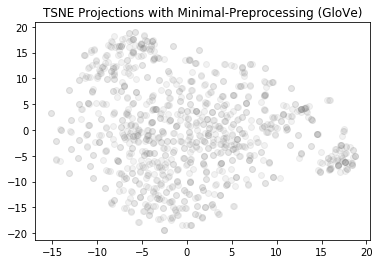

In [193]:
fig, ax = plt.subplots()
ax.scatter(tsne_results_glove[:, 0], tsne_results_glove[:, 1], c='gray', alpha=0.1)
ax.set_title('TSNE Projections with Minimal-Preprocessing (GloVe)')
plt.show()

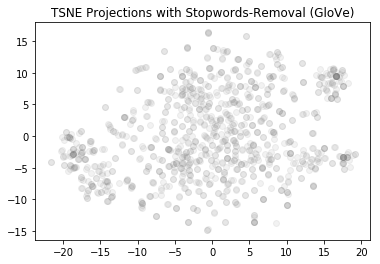

In [196]:
fig, ax = plt.subplots()
ax.scatter(tsne_results_glove_2[:, 0], tsne_results_glove_2[:, 1], c='gray', alpha=0.1)
ax.set_title('TSNE Projections with Stopwords-Removal (GloVe)')
plt.show()

In [69]:
def lemmer(sentlist):  
    wnl = WordNetLemmatizer()
    result = []
    for sentence in sentlist:
        result.append(" ".join([wnl.lemmatize(w) for w in sentence.split()]))
    return result

In [70]:
dat_df_3 = dat_df.copy()
dat_df_3.sen_A = lemmer(dat_df_3.sen_A)
dat_df_3.sen_B = lemmer(dat_df_3.sen_B)

In [71]:
dat_df_3.isna().sum()

sen_A             0
sen_B             0
sim_mean          0
sim_var           0
glove_sims        0
word2vec_sims     0
infersent_sims    0
sen_enc_sims      0
dtype: int64

In [72]:
print_mse_res(dat_df_3)

glove: 1.333031271057277
word2vec: 0.6399756517056833
infersent: 0.566002555027683
transformer: 0.4907815819032301


In [55]:
def stemmer(sentlist, stemmer_fun):
    result = []
    for sentence in sentlist:
        result.append(" ".join([ps.stem(w) for w in sentence.split()]))
    return result

In [56]:
ps = PorterStemmer()
dat_df_4 = dat_df.copy()
dat_df_4.sen_A = stemmer(dat_df_4.sen_A, ps)
dat_df_4.sen_B = stemmer(dat_df_4.sen_B, ps)

In [57]:
dat_df_4.isna().sum()

sen_A             0
sen_B             0
sim_mean          0
sim_var           0
glove_sims        0
word2vec_sims     0
infersent_sims    0
sen_enc_sims      0
dtype: int64

In [58]:
print_mse_res(dat_df_4)

glove: 1.333031271057277
word2vec: 0.6399756517056833
infersent: 0.566002555027683
transformer: 0.4907815819032301


In [60]:
ss = SnowballStemmer('english')
dat_df_4 = dat_df.copy()
dat_df_4.sen_A = stemmer(dat_df_4.sen_A, ss)
dat_df_4.sen_B = stemmer(dat_df_4.sen_B, ss)

In [61]:
dat_df_4.isna().sum()

sen_A             0
sen_B             0
sim_mean          0
sim_var           0
glove_sims        0
word2vec_sims     0
infersent_sims    0
sen_enc_sims      0
dtype: int64

In [62]:
print_mse_res(dat_df_4)

glove: 1.333031271057277
word2vec: 0.6399756517056833
infersent: 0.566002555027683
transformer: 0.4907815819032301


In [63]:
ls = LancasterStemmer()
dat_df_4 = dat_df.copy()
dat_df_4.sen_A = stemmer(dat_df_4.sen_A, ls)
dat_df_4.sen_B = stemmer(dat_df_4.sen_B, ls)

In [64]:
dat_df_4.isna().sum()

sen_A             0
sen_B             0
sim_mean          0
sim_var           0
glove_sims        0
word2vec_sims     0
infersent_sims    0
sen_enc_sims      0
dtype: int64

In [65]:
print_mse_res(dat_df_4)

glove: 1.333031271057277
word2vec: 0.6399756517056833
infersent: 0.566002555027683
transformer: 0.4907815819032301


#### Code for Section 6 in report

In [205]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [216]:
def tag_sentence(sentence, 
                 allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'CONJ']):
    """https://spacy.io/api/annotation"""
    doc = nlp(sentence)
    tag_dict = dict()
    for tag in allowed_postags:
        tag_dict[tag] = set(sorted([str(token) for token in doc if token.pos_ == tag]))
    return tag_dict

In [217]:
dat_df.head()

,sen_A,sen_B,sim_mean,sim_var,glove_sims,word2vec_sims,infersent_sims,sen_enc_sims
0,a girl is riding a horse,a girl is riding a brown horse,4.40,0.490,4.803434,4.669749,4.237167,4.096929
1,a man is riding a skateboard in a park,a man is riding a skateboard,4.77,0.421,4.782162,4.613463,4.294548,4.036732
2,a woman is eating and drinking with other women,some women are eating and drinking,4.92,0.266,4.475363,4.281820,4.324159,4.665819
3,a person is playing a drum,a red car is on the shirt of a man,1.00,0.000,3.621263,1.909154,1.376006,1.600667
4,a cat is resting on a chair,an onion is being cut by a man,1.00,0.000,3.237548,1.369710,1.470808,1.892490


In [220]:
tag_sentence('a dog is not running towards a ball')

{'NOUN': {'ball', 'dog'},
 'ADJ': set(),
 'VERB': {'is', 'running'},
 'ADV': {'not'},
 'CONJ': set(),
 'DET': {'a'},
 'PRON': set()}

In [222]:
sentences = np.concatenate([dat_df.sen_A, dat_df.sen_B])
sentences_tokens = []
for s in tqdm(sentences):
    sentences_tokens.append(tag_sentence(s))

In [482]:
def compute_tokenized_sims(dat_df):
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    glove = pretrained_singleton.glove_model
    word2vec = pretrained_singleton.word2vec_model
    
    sen_tokens = []
    for index, row in tqdm(dat_df.iterrows()):
        sen_a_tokens = tag_sentence(row.sen_A, allowed_postags)
        sen_b_tokens = tag_sentence(row.sen_B, allowed_postags)
        sen_tokens.append((sen_a_tokens, sen_b_tokens))
    
    print('Working on glove...')
    cosine_sims = []
    for sen_a_tokens, sen_b_tokens in sen_tokens:
        tag_cosine_sims = []
        for tag in allowed_postags:
            sen_a_vec = np.zeros(glove.vector_size)
            sen_b_vec = np.zeros(glove.vector_size)
            if (len(sen_a_tokens[tag]) == 0) or (len(sen_b_tokens[tag]) == 0): 
                if (len(sen_a_tokens[tag]) == 0) and (len(sen_b_tokens[tag]) == 0):
                    continue
                else:
                    tag_cosine_sims.append(0.5)
                    continue
            n_a, n_b = 0, 0
            for word in sen_a_tokens[tag]:
                if word in glove: 
                    sen_a_vec += glove[word]
                    n_a += 1
            for word in sen_b_tokens[tag]:
                if word in glove: 
                    sen_b_vec += glove[word]
                    n_b += 1
            sen_a_vec = np.divide(sen_a_vec, n_a)
            sen_b_vec = np.divide(sen_b_vec, n_b)
            tag_cosine_sims.append(1-cosine(sen_a_vec, sen_b_vec))        
        cosine_sims.append(np.mean(tag_cosine_sims))
    dat_df['glove_sims'] = rescale_vec(np.array(cosine_sims).flatten())
    
    print('Working on word2vec...')
    cosine_sims = []
    for sen_a_tokens, sen_b_tokens in sen_tokens:
        tag_cosine_sims = []
        for tag in allowed_postags:
            sen_a_vec = np.zeros(word2vec.vector_size)
            sen_b_vec = np.zeros(word2vec.vector_size)
            if (len(sen_a_tokens[tag]) == 0) or (len(sen_b_tokens[tag]) == 0): 
                if (len(sen_a_tokens[tag]) == 0) and (len(sen_b_tokens[tag]) == 0):
                    continue
                else:
                    tag_cosine_sims.append(0.5)
                    continue
            n_a, n_b = 0, 0
            for word in sen_a_tokens[tag]:
                if word in word2vec: 
                    sen_a_vec += word2vec[word]
                    n_a += 1
            for word in sen_b_tokens[tag]:
                if word in word2vec: 
                    sen_b_vec += word2vec[word]
                    n_b += 1
            sen_a_vec = np.divide(sen_a_vec, n_a)
            sen_b_vec = np.divide(sen_b_vec, n_b)
            tag_cosine_sims.append(1-cosine(sen_a_vec, sen_b_vec))        
        cosine_sims.append(np.mean(tag_cosine_sims))
    dat_df['word2vec_sims'] = rescale_vec(np.array(cosine_sims).flatten())
    return dat_df

In [483]:
dat_df_5 = dat_df.copy()
dat_df_5 = compute_tokenized_sims(dat_df_5)

Working on glove...
Working on word2vec...


#### Results for Section 6 in report

In [484]:
print_mse_res(dat_df_5)

glove: 0.7507962054747196
word2vec: 0.7935510679094099


In [485]:
dat_df_5['upper_true_1sd'] = np.clip(dat_df_5.sim_mean + np.sqrt(dat_df_5.sim_var), 1, 5)
dat_df_5['lower_true_1sd'] = np.clip(dat_df_5.sim_mean - np.sqrt(dat_df_5.sim_var), 1, 5)

dat_df_5['upper_true_2sd'] = np.clip(dat_df_5.sim_mean + 2*np.sqrt(dat_df_5.sim_var), 1, 5)
dat_df_5['lower_true_2sd'] = np.clip(dat_df_5.sim_mean - 2*np.sqrt(dat_df_5.sim_var), 1, 5)

In [486]:
for col in ['glove_sims', 'word2vec_sims']:
    print(col, np.sum((dat_df_5[col] <= dat_df_5.upper_true_1sd) & 
                      (dat_df_5[col] >= dat_df_5.lower_true_1sd)) / dat_df_5.shape[0])

glove_sims 0.5765765765765766
word2vec_sims 0.5693693693693693


In [487]:
for col in ['glove_sims', 'word2vec_sims']:
    print(col, np.sum((dat_df_5[col] <= dat_df_5.upper_true_2sd) & 
                      (dat_df_5[col] >= dat_df_5.lower_true_2sd)) / dat_df_5.shape[0])

glove_sims 0.8
word2vec_sims 0.7837837837837838


In [488]:
outlier_errs = dat_df_5[(dat_df_5.sim_mean < 2.5) & 
                        (dat_df_5.word2vec_sims > 4)]
outlier_errs

,sen_A,sen_B,sim_mean,sim_var,glove_sims,word2vec_sims,upper_true_1sd,lower_true_1sd,upper_true_2sd,lower_true_2sd
222,a dog is not running towards a ball,a dog is running towards a ball,2.2,1.166,3.948004,4.090713,3.279815,1.120185,4.35963,1.0


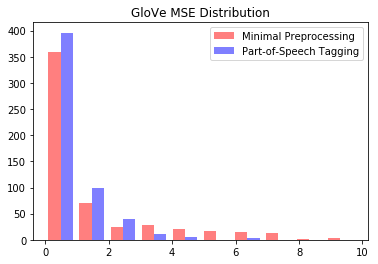

In [493]:
plt.hist([(dat_df_1.sim_mean - dat_df_1.glove_sims)**2,
          (dat_df_5.sim_mean - dat_df_5.glove_sims)**2], 
         color=['r','b'], alpha=0.5, label=['Minimal Preprocessing',
                                            'Part-of-Speech Tagging'])
plt.title("GloVe MSE Distribution")
plt.legend()
plt.show()

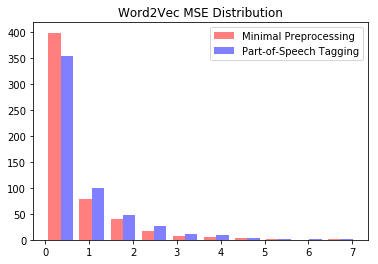

In [494]:
plt.hist([(dat_df_1.sim_mean - dat_df_1.word2vec_sims)**2,
          (dat_df_5.sim_mean - dat_df_5.word2vec_sims)**2], 
         color=['r','b'], alpha=0.5, label=['Minimal Preprocessing',
                                            'Part-of-Speech Tagging'])
plt.title("Word2Vec MSE Distribution")
plt.legend()
plt.show()

In [501]:
sentences = np.concatenate([dat_df_1.sen_A, dat_df_1.sen_B])
sents_vecs = list(get_sents_vecs(sentences))

Found 1119(/1120) words with w2v vectors
Vocab size : 1119
Nb words kept : 12485/12486 (100.0%)
Speed : 30.3 sentences/s (cpu mode, bsize=128)


In [503]:
all_word2vec_vecs = sents_vecs[1]
all_transformer_vecs = sents_vecs[3]
tsne_results_word2vec = tsne.fit_transform(all_word2vec_vecs)
tsne_results_transformer = tsne.fit_transform(all_transformer_vecs)

In [580]:
interest_word2vec_idxs = [50, 190, 400, 820, 900, 800, 480, 1000, 1030]

#### Code for Section 7 in report

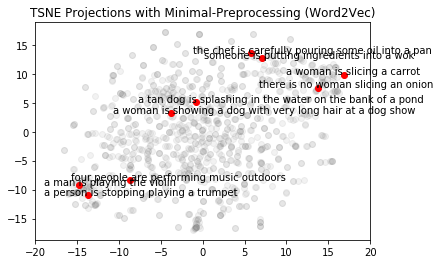

In [582]:
fig, ax = plt.subplots()
ax.scatter(tsne_results_word2vec[:, 0], tsne_results_word2vec[:, 1], c='gray', alpha=0.1)
ax.scatter(tsne_results_word2vec[interest_word2vec_idxs, 0], 
           tsne_results_word2vec[interest_word2vec_idxs, 1], c='red')
for i, v in enumerate(tsne_results_word2vec):
    if i in interest_word2vec_idxs:
        ax.annotate(sentences[i],
                    (max(-19, v[0]-7),
                     v[1]))
ax.set_title('TSNE Projections with Minimal-Preprocessing (Word2Vec)')
ax.set_xlim(-20, 20)
plt.show()

In [606]:
interest_transformer_idxs = [50, 190, 980, 820, 860, 420, 120, 240, 660, 930]

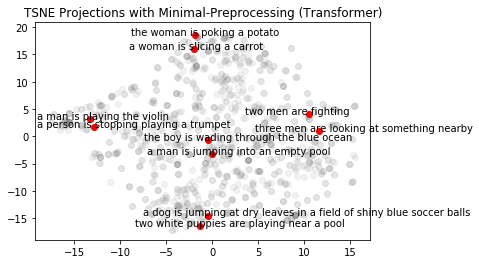

In [607]:
fig, ax = plt.subplots()
ax.scatter(tsne_results_transformer[:, 0], tsne_results_transformer[:, 1], c='gray', alpha=0.1)
ax.scatter(tsne_results_transformer[interest_transformer_idxs, 0], 
           tsne_results_transformer[interest_transformer_idxs, 1], c='red')
for i, v in enumerate(tsne_results_transformer):
    if i in interest_transformer_idxs:
        ax.annotate(sentences[i],
                    (max(-19, v[0]-7),
                     v[1]))
#for i, v in enumerate(tsne_results_transformer):
#    if i % 10 == 0 :
#        ax.annotate(i, (v[0], v[1]))
ax.set_title('TSNE Projections with Minimal-Preprocessing (Transformer)')
plt.show()

In [682]:
pca = PCA(n_components=30, random_state=42)
pca_transformed = pca.fit_transform(all_word2vec_vecs)

In [683]:
np.cumsum(pca.explained_variance_ratio_)[0:2]

array([0.07817949, 0.14717577])

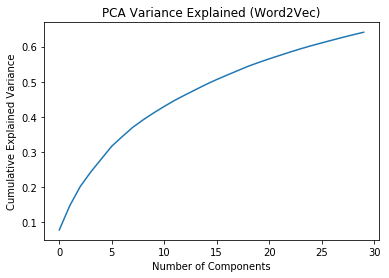

In [619]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained (Word2Vec)')
plt.show()

In [635]:
interest_word2vec_pca_idxs = [920, 280, 650, 200, 400, 110, 28, 62, 52, 46]

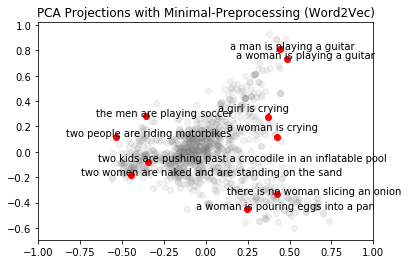

In [651]:
fig, ax = plt.subplots()
ax.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c='gray', alpha=0.1)
ax.scatter(pca_transformed[interest_word2vec_pca_idxs, 0], 
           pca_transformed[interest_word2vec_pca_idxs, 1], c='red')
for i, v in enumerate(pca_transformed):
    if i in interest_word2vec_pca_idxs:
        special_offset = 0
        if (sentences[i] == 'a girl is crying') or (sentences[i] == 'a woman is crying'):
            special_offset = 0.05     
        ax.annotate(sentences[i],
                    (max(-0.9, v[0]-0.3),
                     v[1]+special_offset))
#for i, v in enumerate(pca_transformed):
#    if i < 100:
#        ax.annotate(i, (v[0], v[1]))
ax.set_xlim(-1, 1)
ax.set_title('PCA Projections with Minimal-Preprocessing (Word2Vec)')
plt.show()

In [684]:
pca = PCA(n_components=30, random_state=42)
pca_transformed = pca.fit_transform(all_transformer_vecs)

In [685]:
print(np.cumsum(pca.explained_variance_ratio_)[0:2])

[0.09288328 0.16680884]


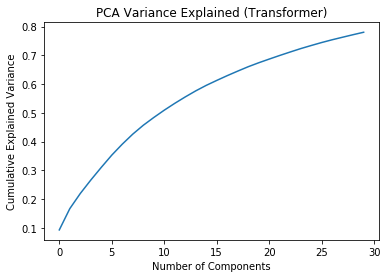

In [653]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained (Transformer)')
plt.show()

In [678]:
interest_transformer_pca_idxs = [107, 1, 164, 182, 184, 29, 
                                 45, 143, 133, 230, 327, 372]

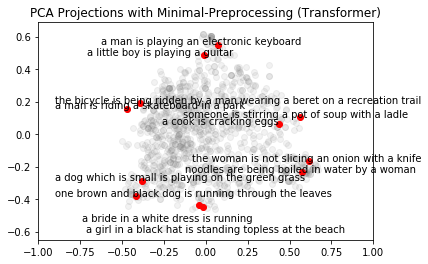

In [679]:
fig, ax = plt.subplots()
ax.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c='gray', alpha=0.1)
ax.scatter(pca_transformed[interest_transformer_pca_idxs, 0], 
           pca_transformed[interest_transformer_pca_idxs, 1], c='red')
for i, v in enumerate(pca_transformed):
    if i in interest_transformer_pca_idxs:
        special_offset = 0
        if (sentences[i] == 'a bride in a white dress is running'):
            special_offset = -0.1
        if (sentences[i] == 'a girl in a black hat is standing topless at the beach'):
            special_offset = -0.15
        ax.annotate(sentences[i],
                    (max(-0.9, v[0]-0.7),
                     v[1]+special_offset))
#for i, v in enumerate(pca_transformed):
#    if (i >300) & (i<400):
#        ax.annotate(i, (v[0], v[1]))
ax.set_xlim(-1, 1)
ax.set_title('PCA Projections with Minimal-Preprocessing (Transformer)')
plt.show()

In [723]:
data = all_word2vec_vecs
# k means determine k
K = range(5, 15)
inertia = []
sil_score = []
for k in tqdm(K):
    model = KMeans(init='k-means++', n_clusters=k, random_state=42).fit(data)
    inertia.append(model.inertia_)
    sil_score.append(metrics.silhouette_score(data, model.labels_))

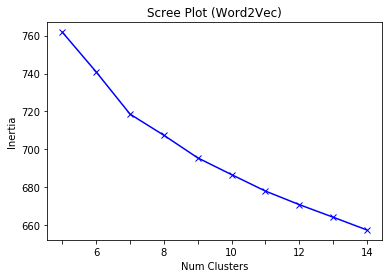

In [724]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('Num Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot (Word2Vec)')
plt.xticks(range(5, 15), [x if x%2==0 else '' for x in range(5, 15)])
plt.show()

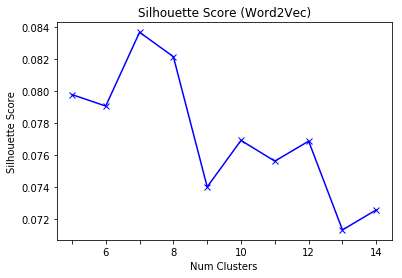

In [725]:
# Plot the elbow
plt.plot(K, sil_score, 'bx-')
plt.xlabel('Num Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score (Word2Vec)')
plt.xticks(range(5, 15), [x if x%2==0 else '' for x in range(5, 15)])
plt.show()

In [713]:
data = all_transformer_vecs
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # k means determine k
    K = range(5, 25)
    inertia = []
    sil_score = []
    for k in tqdm(K):
        model = KMeans(init='k-means++', n_clusters=k, 
                       random_state=42).fit(data)
        inertia.append(model.inertia_)
        sil_score.append(metrics.silhouette_score(data, model.labels_))

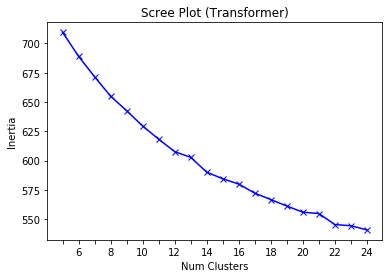

In [721]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('Num Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot (Transformer)')
plt.xticks(range(5, 25), [x if x%2==0 else '' for x in range(5, 25)])
plt.show()

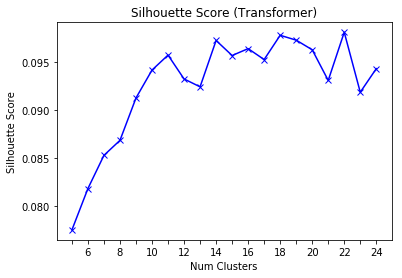

In [720]:
# Plot the elbow
plt.plot(K, sil_score, 'bx-')
plt.xlabel('Num Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(5, 25), [x if x%2==0 else '' for x in range(5, 25)])
plt.title('Silhouette Score (Transformer)')
plt.show()

In [731]:
data = all_word2vec_vecs
model = KMeans(init='k-means++', n_clusters=7, 
                       random_state=42).fit(data)

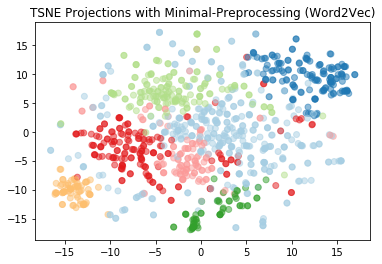

In [737]:
fig, ax = plt.subplots()
cols = sns.color_palette("Paired")
ax.scatter(tsne_results_word2vec[:, 0], 
           tsne_results_word2vec[:, 1], 
           c=[cols[i] for i in model.labels_],
           alpha=0.5)
ax.set_title('TSNE Projections with Minimal-Preprocessing (Word2Vec)')
#ax.set_xlim(-20, 20)
plt.show()

In [738]:
data = all_transformer_vecs
model = KMeans(init='k-means++', n_clusters=14, 
                       random_state=42).fit(data)

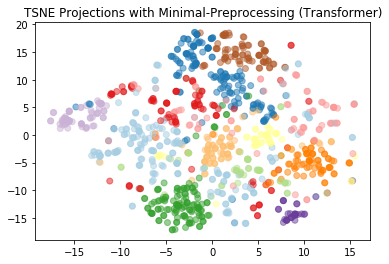

In [743]:
fig, ax = plt.subplots()
cols = sns.color_palette("Paired", 20)
ax.scatter(tsne_results_transformer[:, 0], 
           tsne_results_transformer[:, 1], 
           c=[cols[i] for i in model.labels_],
           alpha=0.5)
ax.set_title('TSNE Projections with Minimal-Preprocessing (Transformer)')
#ax.set_xlim(-20, 20)
plt.show()